## Imports and Utilities

In [53]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
import qiskit.visualization as qvis
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np

# selection of quantum simulator (or processor)
backend = Aer.get_backend("qasm_simulator")

In [79]:
def plot_circuit(circuit: QuantumCircuit, *, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111)
    circuit.draw("mpl", ax=ax)
    return ax


def plot_circuit_and_results(
    circuit: QuantumCircuit,
    counts: list[dict],
    *,
    figsize: tuple[float, float] = (15, 8),
) -> plt.Figure:
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2)

    axs = [
        fig.add_subplot(gs[0, :]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[1, 1]),
    ]

    plot_circuit(circuit, ax=axs[0])
    qvis.plot_histogram(
        counts,
        ax=axs[1],
    )
    qvis.plot_distribution(
        counts,
        legend=[f"Execution {i + 1}" for i in range(len(counts))],
        ax=axs[2],
    )

    for ax in (axs[1], axs[2]):
        old_texts = ax.texts[:]  # copy list of text objects
        for t in old_texts:
            t.remove()

    for ax in (axs[1], axs[2]):
        for p in ax.patches:  # each bar
            height = p.get_height()
            x = p.get_x() + p.get_width() / 2
            ax.annotate(
                f"{height}" if float(height).is_integer() else f"{height:.2f}",
                (x, height),
                ha="center",
                va="bottom",
                rotation=45,
                fontsize=9,
            )

    axs[0].set_title("Circuit")
    axs[1].set_title("Distribution [counts]")
    axs[2].set_title("Probabilities")
    return fig


def run_experiments(
    backend, circuit: QuantumCircuit, *, shots: int = 2048, runs: int = 3
) -> list[dict]:
    compiled_circuit = transpile(circuit, backend)
    return [
        backend.run(compiled_circuit, shots=shots).result().get_counts()
        for _ in range(runs)
    ]

In [48]:
@dataclass
class Setup:
    n: int
    qx: QuantumRegister
    cx: ClassicalRegister
    circuit: QuantumCircuit

    @classmethod
    def create(cls) -> "Setup":
        n = 2
        qx = QuantumRegister(n, "q")
        cx = ClassicalRegister(n, "c")
        circ = QuantumCircuit(qx, cx)
        return cls(n, qx, cx, circ)

In [49]:
def connect_bell_state(setup: Setup) -> None:
    setup.circuit.x(setup.qx[0])
    setup.circuit.x(setup.qx[1])
    setup.circuit.h(setup.qx[0])
    setup.circuit.cx(setup.qx[0], setup.qx[1])


def connect_barrier(setup: Setup) -> None:
    qbits = [setup.qx[i] for i in range(setup.n)]
    setup.circuit.barrier(*qbits)


def connect_x_hat(setup: Setup, qbit: int) -> None:
    setup.circuit.h(setup.qx[qbit])


def connect_w_hat(setup: Setup, qbit: int) -> None:
    setup.circuit.s(setup.qx[qbit])
    setup.circuit.h(setup.qx[qbit])
    setup.circuit.t(setup.qx[qbit])
    setup.circuit.h(setup.qx[qbit])


def connect_z_hat(setup: Setup, qbit: int) -> None:
    return


def connect_v_hat(setup: Setup, qbit: int) -> None:
    setup.circuit.s(setup.qx[qbit])
    setup.circuit.h(setup.qx[qbit])
    setup.circuit.tdg(setup.qx[qbit])
    setup.circuit.h(setup.qx[qbit])


def connect_measurements(setup: Setup) -> None:
    for i in range(setup.n):
        setup.circuit.measure(setup.qx[i], setup.cx[i])

In [50]:
def create_x_w_setup() -> Setup:
    setup = Setup.create()

    connect_bell_state(setup)
    connect_barrier(setup)
    connect_x_hat(setup, 1)
    connect_w_hat(setup, 0)
    connect_barrier(setup)
    connect_measurements(setup)
    return setup


def create_x_v_setup() -> Setup:
    setup = Setup.create()

    connect_bell_state(setup)
    connect_barrier(setup)
    connect_x_hat(setup, 1)
    connect_v_hat(setup, 0)
    connect_barrier(setup)
    connect_measurements(setup)
    return setup


def create_z_w_setup() -> Setup:
    setup = Setup.create()

    connect_bell_state(setup)
    connect_barrier(setup)
    connect_z_hat(setup, 1)
    connect_w_hat(setup, 0)
    connect_barrier(setup)
    connect_measurements(setup)
    return setup


def create_z_v_setup() -> Setup:
    setup = Setup.create()

    connect_bell_state(setup)
    connect_barrier(setup)
    connect_z_hat(setup, 1)
    connect_v_hat(setup, 0)
    connect_barrier(setup)
    connect_measurements(setup)
    return setup

In [60]:
def calculate_expectation_value(result: dict) -> float:
    def _calc_bit_string_product(bit_string: str) -> int:
        product = 1
        for bit in bit_string:
            if bit == "0":
                product *= 1
            else:
                product *= -1
        return product

    counts = np.array(list(result.values()))
    probs = counts / counts.sum()
    products = np.array(
        [_calc_bit_string_product(bit_string) for bit_string in result.keys()]
    )

    expectation_value = np.sum(products * probs)
    return expectation_value


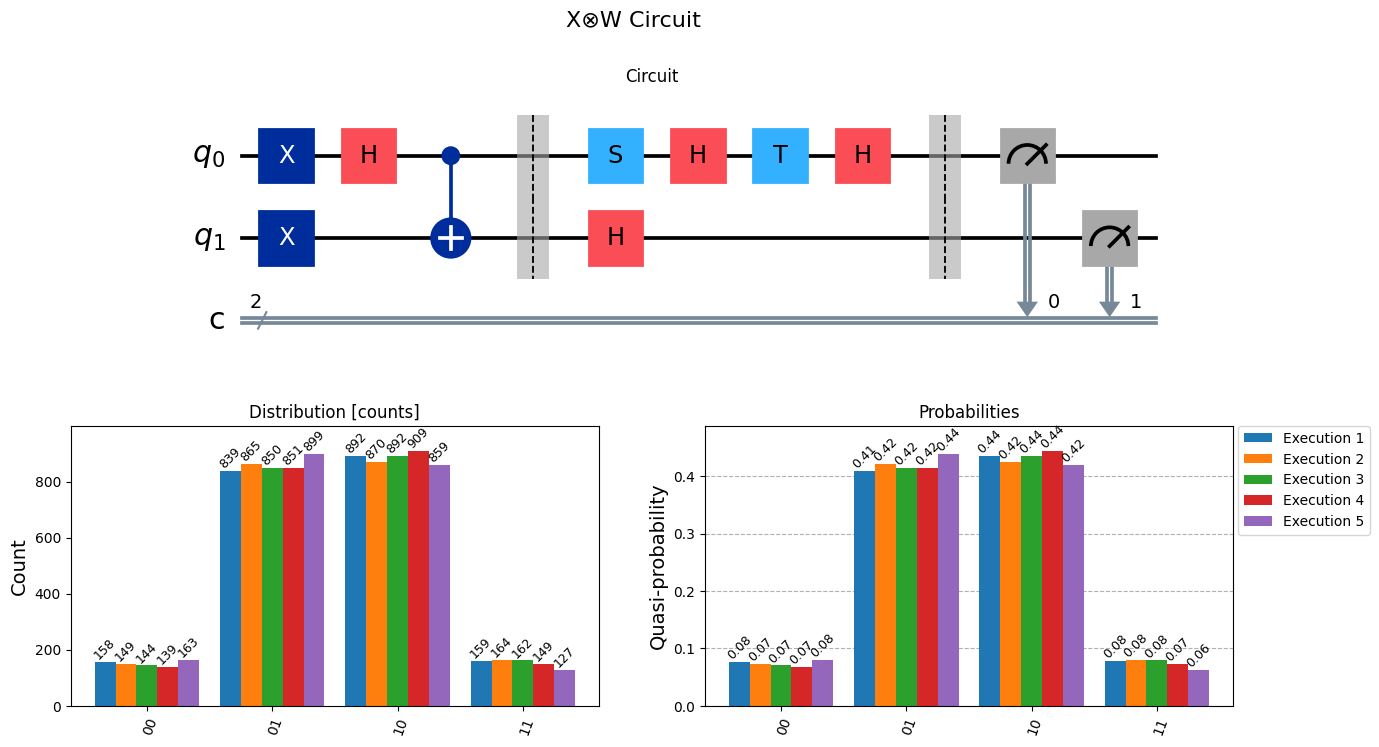

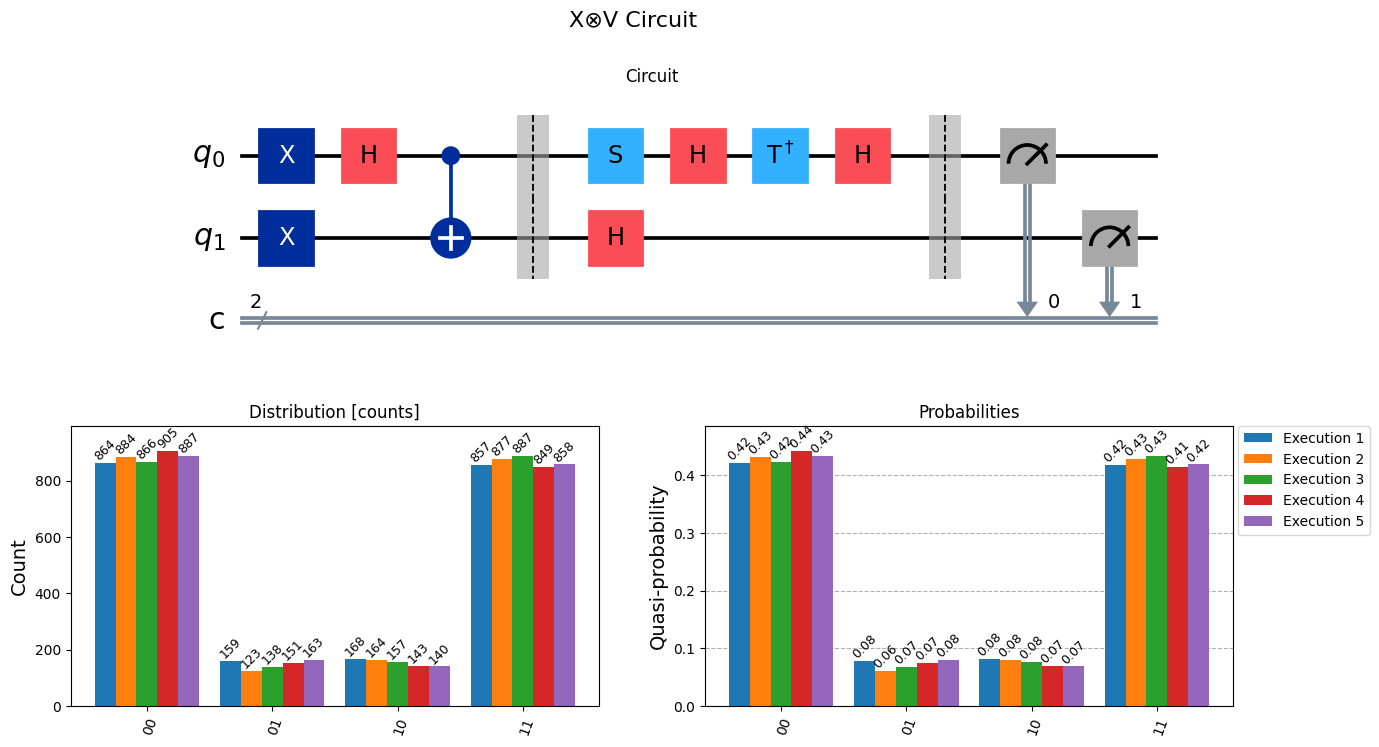

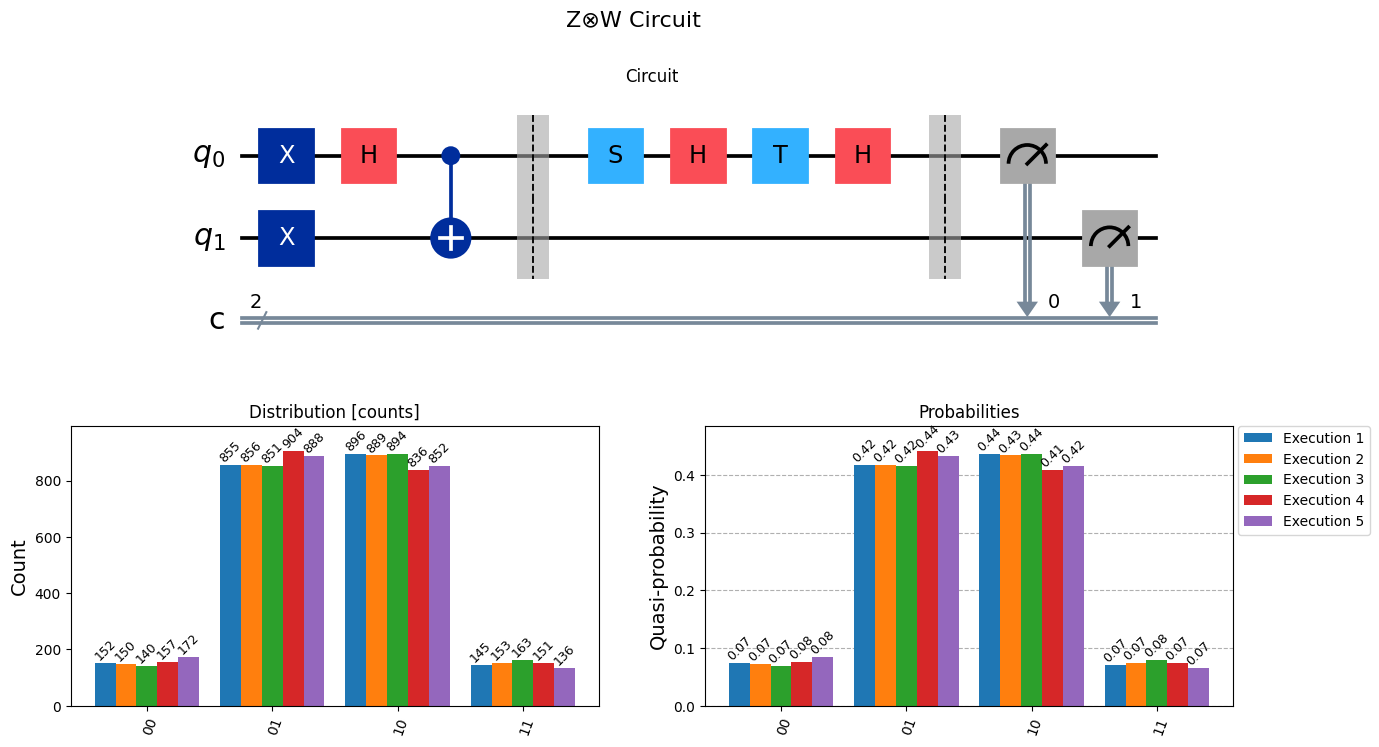

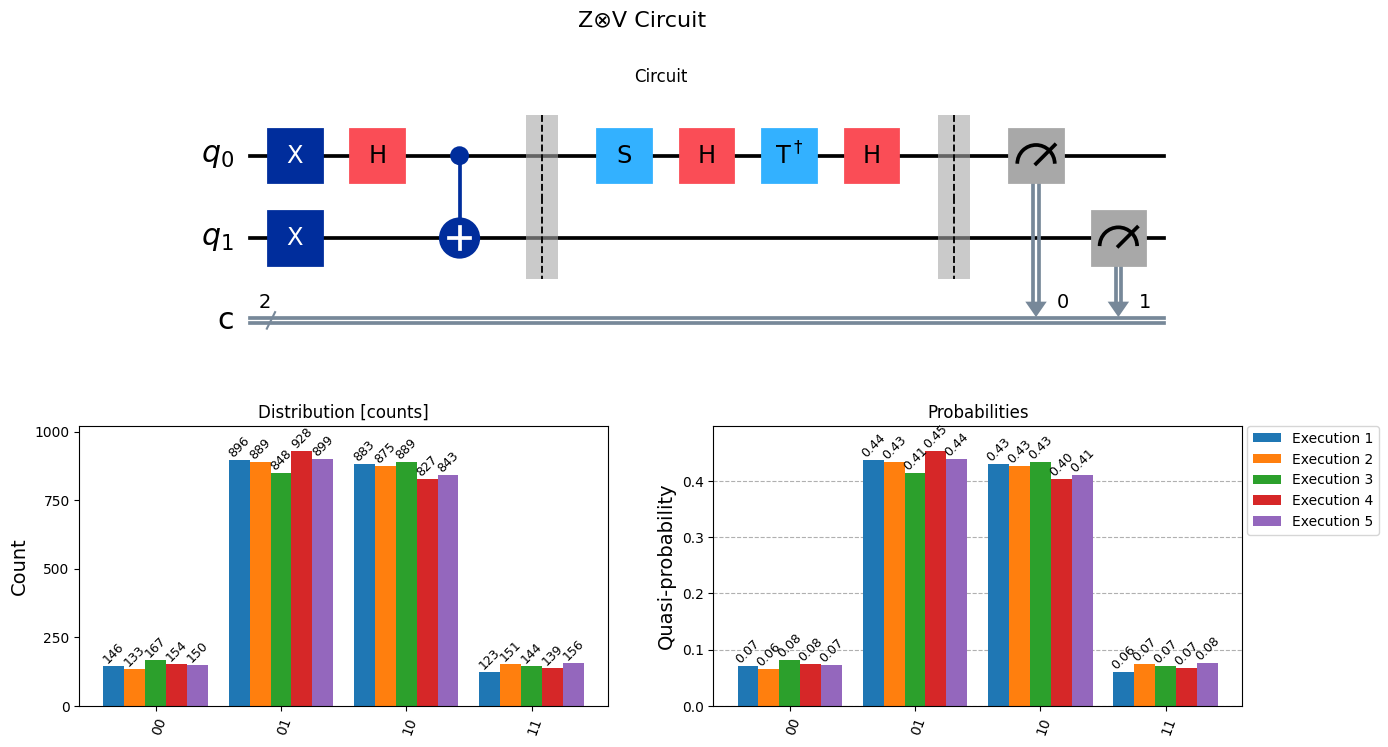

In [80]:
RUNS = 5

a_posteriori_values = [0 for _ in range(RUNS)]
for setup_func, suptitle, exp_mult in [
    (create_x_w_setup, "X⊗W Circuit", 1),
    (create_x_v_setup, "X⊗V Circuit", -1),
    (create_z_w_setup, "Z⊗W Circuit", 1),
    (create_z_v_setup, "Z⊗V Circuit", 1),
]:
    setup = setup_func()
    results = run_experiments(backend, setup.circuit, shots=2048, runs=RUNS)

    for i, result in enumerate(results):
        a_posteriori_values[i] += exp_mult * calculate_expectation_value(result)

    fig = plot_circuit_and_results(
        setup.circuit,
        results,
    )
    fig.suptitle(suptitle, fontsize=16)
    plt.show()

In [81]:
a_posteriori_series = pd.Series(a_posteriori_values, name="A-posteriori values")

print(a_posteriori_series)

print(
    f"|A-posteriori value|: {np.abs(a_posteriori_series.mean()):.4f} ± {a_posteriori_series.std(ddof=1):.4f}"
)
print("Classical limit: 2.0")
print(f"Quantum limit: 2√2 ≈ {2 * np.sqrt(2):.4f}")

0   -2.818359
1   -2.840820
2   -2.813477
3   -2.844727
4   -2.821289
Name: A-posteriori values, dtype: float64
|A-posteriori value|: 2.8277 ± 0.0141
Classical limit: 2.0
Quantum limit: 2√2 ≈ 2.8284
